<a href="https://colab.research.google.com/github/wiecz0r/computer_vision_AGH/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip "/content/drive/My Drive/AGH/2_mag/Widzenie Komputerowe/Neural Style Transfer/hiragana.zip" -d "/content/drive/My Drive/AGH/2_mag/Widzenie Komputerowe/Neural Style Transfer/hiragana"

# Neural Style Transferring
## Szymon Wieczorek

#### Importy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from IPython.display import Image, display

Poniżej zostały umieszczone funkcje zapożyczone z tutoriala kerasowego:

In [ ]:
def prepare_images(base_path, style_path):
  b = preprocess_image(base_path)
  s = preprocess_image(style_path)
  c = tf.Variable(preprocess_image(base_path))
  return b, s, c

In [ ]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

Poniżej funkcja do trenowania NST

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

def train():
  for i in range(1, iterations + 1):
      loss, grads = compute_loss_and_grads(
          combination_image, base_image, style_reference_image
      )
      optimizer.apply_gradients([(grads, combination_image)])
      if i % 100 == 0:
          print("Iteration %d: loss=%.2f" % (i, loss))
          img = deprocess_image(combination_image.numpy())
          fname = "_at_iteration_%d.png" % i
          keras.preprocessing.image.save_img(result_prefix + fname, img)

Ustalenie wag oraz ilości iteracji, próbowałem kilku róznych wag, postanowiłem użyć poniższych

In [ ]:
# Weights of the different loss components
total_variation_weight = 1e-5
style_weight = 1e-7
content_weight = 2.5e-8

iterations = 600

Ilość iteracji nie jest duża, poniważ większa ilość wiązałaby się z dużo dłuższym przetwarzaniem, na co w warunkach domowych nie mogłem sobie pozwolić

W kodzie poniżej zaprezentowane zostało NST dla każdej z liter w zbiorze hiragana (po 1 przykładzie na literę )

------- A -------


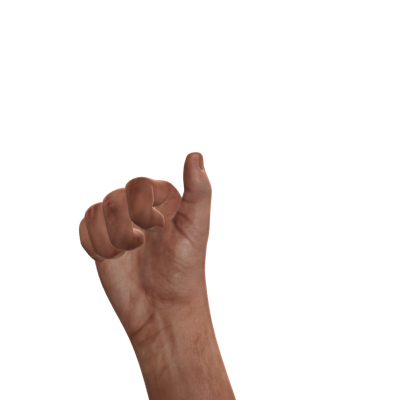

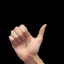

Iteration 100: loss=575.47
Iteration 200: loss=447.93
Iteration 300: loss=396.58
Iteration 400: loss=367.28
Iteration 500: loss=347.61
Iteration 600: loss=333.15
------- I -------


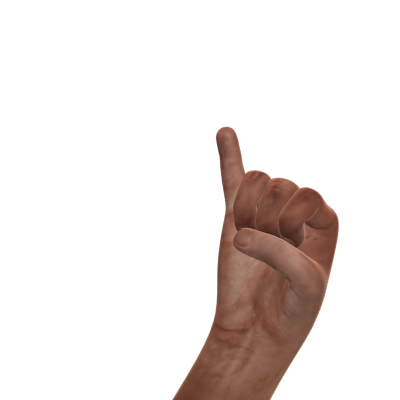

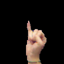

Iteration 100: loss=508.30
Iteration 200: loss=359.36
Iteration 300: loss=302.93
Iteration 400: loss=271.99
Iteration 500: loss=252.19
Iteration 600: loss=238.15
------- U -------


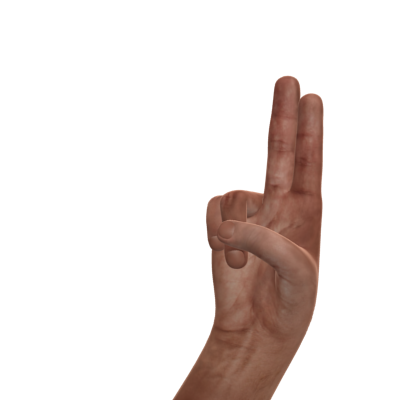

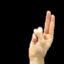

Iteration 100: loss=827.73
Iteration 200: loss=615.45
Iteration 300: loss=535.07
Iteration 400: loss=489.82
Iteration 500: loss=460.19
Iteration 600: loss=438.98
------- E -------


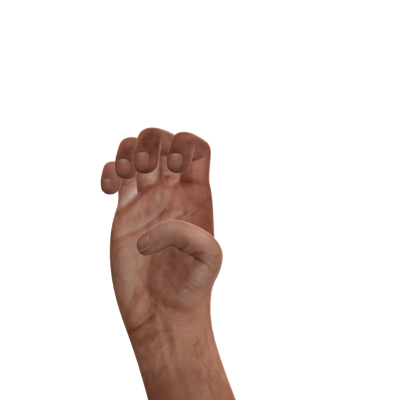

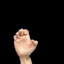

Iteration 100: loss=732.32
Iteration 200: loss=503.19
Iteration 300: loss=420.67
Iteration 400: loss=376.19
Iteration 500: loss=347.66
Iteration 600: loss=327.50
------- O -------


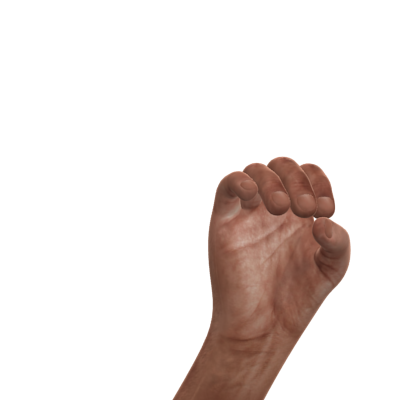

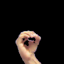

Iteration 100: loss=929.77
Iteration 200: loss=633.61
Iteration 300: loss=525.09
Iteration 400: loss=467.10
Iteration 500: loss=430.17
Iteration 600: loss=404.15


In [ ]:
folder_path = "/content/drive/My Drive/AGH/2_mag/Widzenie Komputerowe/Neural Style Transfer/"
base_prefix = "hiragana/synthetic_8_frames_RGBA/"
style_prefix = "hiragana/real_train/"
base_images = [
               "01_a/01_a.000_Camera.001_0000.png",
               "02_i/02_i.000_Camera.001_0000.png",
               "03_u/03_u.000_Camera.001_0000.png",
               "04_e/04_e.000_Camera.001_0000.png",
               "05_o/05_o.000_Camera.001_0000.png"
               ]
style_images = [
                "01_a/real_train_01_a_0.png",
                "02_i/real_train_02_i_0.png",
                "03_u/real_train_03_u_0.png",
                "04_e/real_train_04_e_0.png",
                "05_o/real_train_05_o_0.png"
                ]

prefixes = ["a","i","u","e","o"]

for i in range(len(prefixes)):
  result_prefix = folder_path + prefixes[i]
  base_path = folder_path + base_prefix + base_images[i]
  style_path = folder_path + style_prefix + style_images[i]

  # Dimensions of the generated picture.
  width, height = keras.preprocessing.image.load_img(base_image_path).size
  img_nrows = 400
  img_ncols = int(width * img_nrows / height)
  print("------- " + prefixes[i].upper() + " -------")
  display(Image(base_path, width=70))
  display(Image(style_path, width=70))

  base_image, style_reference_image, combination_image = prepare_images(base_path, style_path)

  train()

loss generalnie był na niskim poziomie, największy był dla literki "U".
<br> Poniżej zostało przedstawione zestawienie dla każdej z literek:

------- A -------
Base:


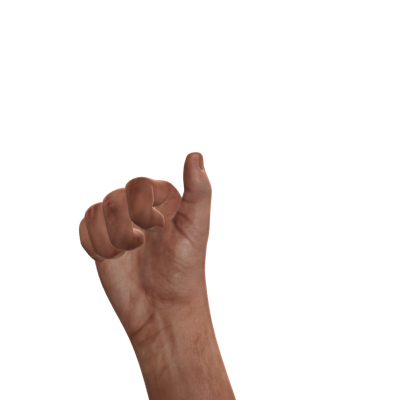

Style:


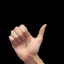

Result:


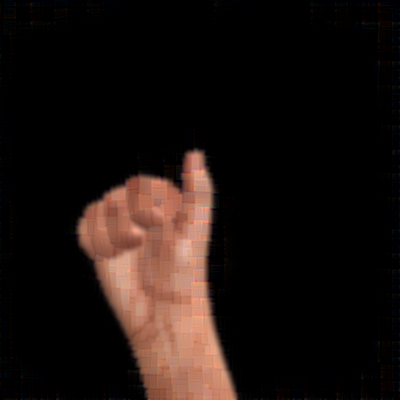

------- I -------
Base:


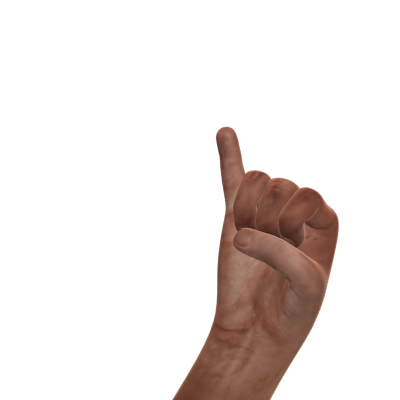

Style:


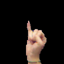

Result:


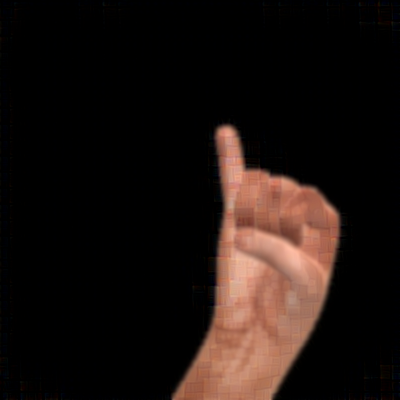

------- U -------
Base:


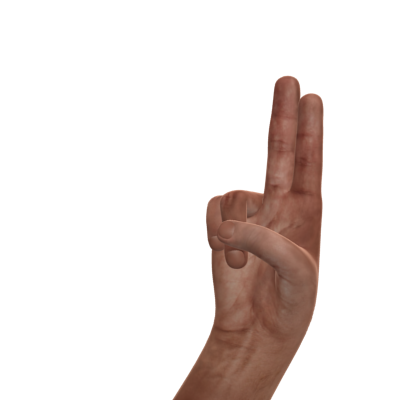

Style:


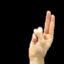

Result:


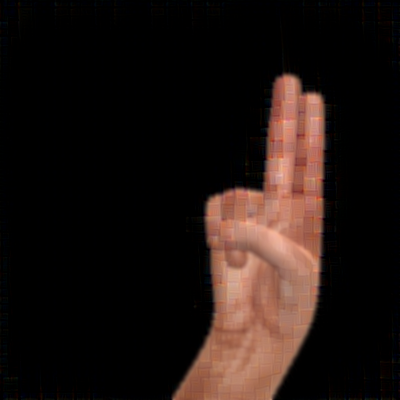

------- E -------
Base:


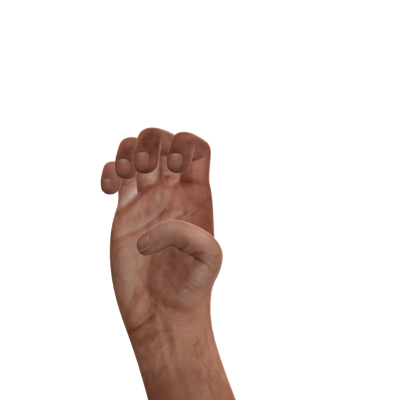

Style:


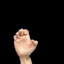

Result:


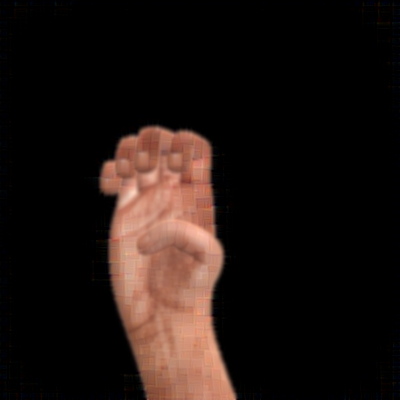

------- O -------
Base:


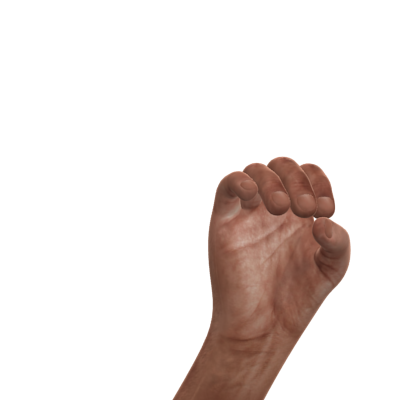

Style:


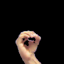

Result:


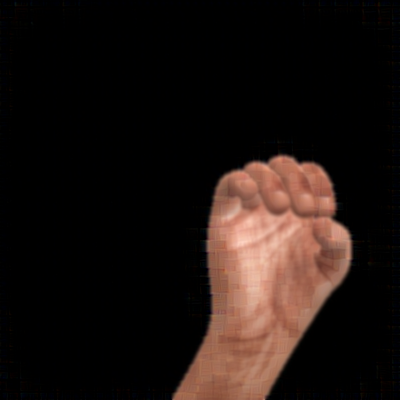

In [ ]:
for i in range(len(prefixes)):
  print("------- " + prefixes[i].upper() + " -------")
  print("Base:")
  display(Image(folder_path + base_prefix + base_images[i], width=200))
  print("Style:")
  display(Image(folder_path + style_prefix + style_images[i], width=200))
  print("Result:")
  display(Image(folder_path + prefixes[i] + "_at_iteration_600.png", width=200))

Niestety, wyniki nie są obiecujące - uzyskane obrazki nie różnią się w znaczący sposób od podstawowych, jednak widać pewne różnice, dłonie mają delikatnie jaśniejszy kolor skóry. Prawdopodobnie jest to wynik nie do końca dobrego dobrania wag oraz ilości iteracji. Tak czy siak udało się pokazać, że Neural Style Transferring działa, nie "niszczy" obrazków. <br> Generalnie w NST bardzo dobre efekty są widoczne dla obrazków znacząco różniących się stylem ( base / style ). W tym przypadku mieliśmy do czynienia z bardzo podobnymi obrazkami, różniących się de facto tylko kolorem skóry.